This data comes from Taarifa's dashboards which aggregate data from the Tanzanian Ministry of Water. It was made available so that citizens can stay engaged with the local government and hold them accountable. The dataset includes 40 features from almost 75,000 water pumps across the country. Examples of some of the features include geographic location of waterpumps, water quality and quantity measures, the companies that install, fund and maintain the pumps, and whether communities are paying for the water.

The government's goal is to provide clean water to communities across the country. By understanding which pumps might fail, they can improve maintenance and operations. 

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import sklearn

In [2]:
# Import csv files
train = pd.read_csv("train_values.csv")
test = pd.read_csv("test_values.csv")
train_labels = pd.read_csv("train_labels.csv")

In [3]:
# Drop unnamed columns with blank values
train_labels = train_labels.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

We want to merge the train_labels dataset with the train dataset on the key 'id.' This is because we want the target values in the dataset which we train our model on. 

In [4]:
# Merge train and train labels
train_data = pd.merge(train, train_labels, how='inner', on=['id'])

In [5]:
# Print shape of train and test data 

train_shape = train_data.shape
test_shape = test.shape
print(train_shape, test_shape)

(59400, 41) (14850, 40)


Status_group in the dataset train_labels is the column that contains the target values we're trying to predict in the test data. Below, we visualize the values of status_group to get a sense of the distribution of waterpumps that are functional, non-functional, or that need repair. 

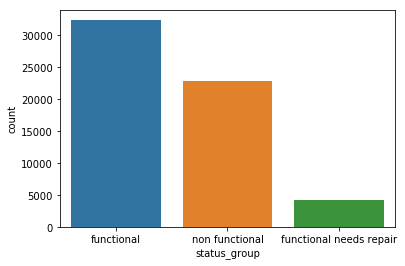

In [6]:
# Explore counts of the status group by category

sns.countplot(train_labels["status_group"])
plt.show()

In [7]:
# Assess which variables are integers, objects, or floats and how many null values exist in train dataset

print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null object
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
re

There are 40 features in the train dataset, but not all of them are relevant to our prediction. We'll want to remove any columns that aren't relevant to predicting the water pump functionality, those columns with so much missing information that we might deem them unusable, and columns with redundant information.

The following are columns with information that's redundant to other columns in the dataset. 
* payment_type: Redundant column to payment
* quality_group: Nearly redundant to water_quality; 1 less category
* quantity_group: Redundant column to quantity 
* extraction_type_group: Almost identical to extraction_type variable 
* scheme_management: Almost identical to management, but this variable has missing values

The following columns aren't usable: 
* num_private: 99% of the data in this column is missing
* amount_tsh: >80% of the values are missing
* date_recorded: Not relevant to target variable
* recorded_by: All data was recorded by GeoData Consultants Ltd.
* id: id number doesn't contain information for prediction since each value is unique
* wpt_name: Each waterpoint has a unique name so this feature also isn't helpful for prediction

In [8]:
# Drop columns that aren't relevant to the model except id so that it can be used for submission

def drop_columns(dataset, list):
        return dataset.drop(list, axis=1)
        
list = ['num_private', 'amount_tsh', 'date_recorded' ,'recorded_by', 'wpt_name', 'payment_type', 'quality_group', 'quantity_group', 'extraction_type_group', 
        'scheme_management']
train_data = drop_columns(train_data, list)

In [9]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 31 columns):
id                       59400 non-null int64
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
scheme_name              31234 non-null object
permit                   56344 non-null object
construction_year        59400 non-null int64
extraction_type          59400 non-null object
ex

Let's look at descriptive statistics for each variable to understand the nature of our data. First, we'll look at the value counts for each categorical variable (object). Then, we'll look at integers and floats. 

In [10]:
# Subset dataframe for those variables that are objects

obj_columns = train_data.select_dtypes(include=['object'])

In [11]:
# Print value_counts for all object series

for i in obj_columns.columns: 
    print(obj_columns[i].value_counts())

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
0                          777
Norad                      765
Germany Republi            610
Tcrs                       602
Ministry Of Water          590
Water                      583
Dwe                        484
Netherlands                470
Hifab                      450
Adb                        448
Lga                        442
Amref                      425
Fini Water                 393
Oxfam                      359
Wateraid                   333
Rc Church                  321
Isf                        316
                          ... 
Mtambo                       1
Ruvu Dar

In [12]:
# Subset dataframe for those variables that are ints and floats

intflt_columns = train_data.select_dtypes(include=['int64', 'float64'])

In [13]:
for i in intflt_columns.columns: 
    print(intflt_columns[i].describe())

count    59400.000000
mean     37115.131768
std      21453.128371
min          0.000000
25%      18519.750000
50%      37061.500000
75%      55656.500000
max      74247.000000
Name: id, dtype: float64
count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64
count    59400.000000
mean        34.077427
std          6.567432
min          0.000000
25%         33.090347
50%         34.908743
75%         37.178387
max         40.345193
Name: longitude, dtype: float64
count    5.940000e+04
mean    -5.706033e+00
std      2.946019e+00
min     -1.164944e+01
25%     -8.540621e+00
50%     -5.021597e+00
75%     -3.326156e+00
max     -2.000000e-08
Name: latitude, dtype: float64
count    59400.000000
mean        15.297003
std         17.587406
min          1.000000
25%          5.000000
50%         12.000000
75%         17.000000
max         99.000000

There are several different variables that describe the location of the water pumps. Latitude and longitude are the only continuous variables. Let's plot these to get a sense of what they look like by the water pump status. 

In [14]:
# Split training data into 3 datasets based on status of water pump

functional = train_data[train_data["status_group"] == 'functional']
non_functional = train_data[train_data["status_group"] == 'non functional']
functional_w_repair = train_data[train_data["status_group"] == 'functional needs repair']

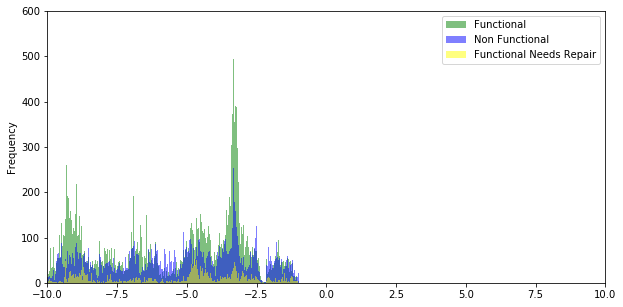

In [15]:
# Plot histogram of latitude by frequency for each water pump status

functional["latitude"].plot.hist(alpha=0.5,color='green',bins=500, xlim = (-10, 10), ylim = (0, 600), figsize = (10,5))
non_functional["latitude"].plot.hist(alpha=0.5,color='blue',bins=500)
functional_w_repair["latitude"].plot.hist(alpha=0.5,color='yellow',bins=500)
plt.legend(['Functional','Non Functional', 'Functional Needs Repair'])
plt.show()

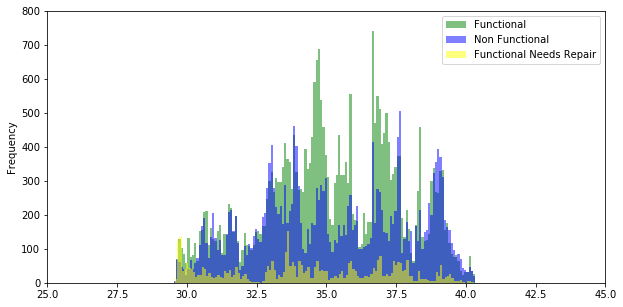

In [16]:
# Plot histogram of longitude by frequency for each water pump status

functional["longitude"].plot.hist(alpha=0.5,color='green',bins=500, xlim = (25, 45), ylim = (0, 800), figsize = (10,5))
non_functional["longitude"].plot.hist(alpha=0.5,color='blue',bins=500)
functional_w_repair["longitude"].plot.hist(alpha=0.5,color='yellow',bins=500)
plt.legend(['Functional','Non Functional', 'Functional Needs Repair'])
plt.show()

We might also want to further explore the population and construction year variables since we learned from the descriptions above that there are zero values. Plotting the histogram below shows us that there are almost 18,000 values in the column population equal to 0. It wouldn't make sense that the government would build so many water pumps in areas where there are no people. It's more likely that the data is misisng.

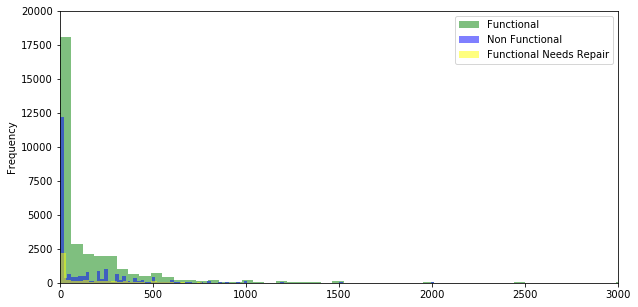

In [17]:
# Plot histogram of population (x-axis) against frequency (y-axis)

functional["population"].plot.hist(alpha=0.5,color='green',bins=500, xlim = (0, 3000), ylim = (0, 20000), figsize = (10,5))
non_functional["population"].plot.hist(alpha=0.5,color='blue',bins=500)
functional_w_repair["population"].plot.hist(alpha=0.5,color='yellow',bins=500)
plt.legend(['Functional','Non Functional', 'Functional Needs Repair'])
plt.show()

Below, I've plotted construction years with a value of 0, and all other values for construction_year separately. Both are plotted by the water pump status. There are more than 10,000 missing values in this column. It looks like a disproportionately large % of non functional water pumps have 0 (missing values).

For those values in construction year with non-missing data, eyeballing the data shows that pumps constructed more recently are more likely to be functional. This makes intuitive sense. 

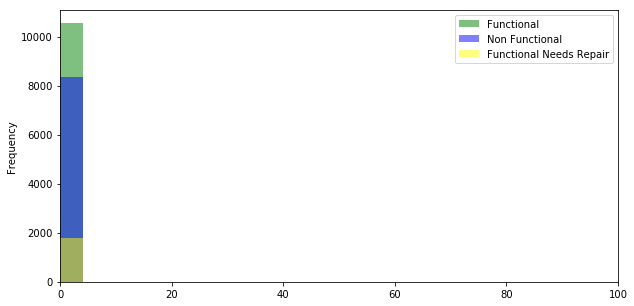

In [18]:
# Plot construction years that are from 0 to 100 against frequency

functional["construction_year"].plot.hist(alpha=0.5,color='green',bins=500, xlim = (0, 100), figsize = (10,5))
non_functional["construction_year"].plot.hist(alpha=0.5,color='blue',bins=500)
functional_w_repair["construction_year"].plot.hist(alpha=0.5,color='yellow',bins=500)
plt.legend(['Functional','Non Functional', 'Functional Needs Repair'])
plt.show()

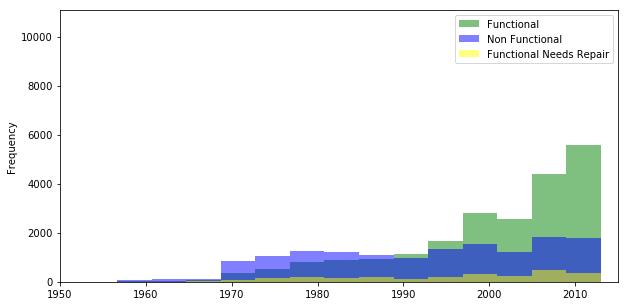

In [19]:
# Plot construction years that are from 1950 to 2015 by water pump outcome

functional["construction_year"].plot.hist(alpha=0.5,color='green',bins=500, xlim = (1950, 2015), figsize = (10,5))
non_functional["construction_year"].plot.hist(alpha=0.5,color='blue',bins=500)
functional_w_repair["construction_year"].plot.hist(alpha=0.5,color='yellow',bins=500)
plt.legend(['Functional','Non Functional', 'Functional Needs Repair'])
plt.show()

Missing data: Analyzing descriptive statistics shows us that some features have several 0 values. For example, about 50% of the data in construction year is 0. This only makes sense if 0 was used to denote missing data. We don't want to leave these values as 0 because it will skew the data. Instead, we can fill the 0 values with the column average for all integers.

In [20]:
# Fill 0 values for population and construction year with mean of the respective columns

def replace_mean(dataset, column, mean):
    return dataset[column].replace(0, mean)

pop_mean = train_data["population"].mean()
const_mean = train_data["construction_year"].mean()
train_data["population"] = replace_mean(train_data, "population", pop_mean)
train_data["construction_year"] = replace_mean(train_data, "construction_year", const_mean)

Our graphs above also show that both population and construction year might be more powerful features in our model if we bin them, or convert them into categorical variables. I did this based on eyeballing trends in the data.

In [21]:
# Create categories from integer variable population
def cats(dataset, column, cut, labels):
    return pd.cut(dataset[column], cut, labels)

cut_cons = [1950, 1970, 1990, 2010]
labels_cons = ['1950 to 1970','1970 to 1990', '1990 to 2010']
train_data["construction_year"] = cats(train_data, "construction_year", cut_cons, labels_cons)

cut_pop = [0, 300, 1500, 30000]
labels_pop = ['0 to 300', '300 to 1500', '1500 to 30000']
train_data["population"] = cats(train_data, "population", cut_pop, labels_pop)

In [22]:
# Map each categorical label to an integer so that model can interpret it
def remap(dataset, column, mapping):
    return dataset[column].map(mapping)

train_data["population"] = remap(train_data, "population", {'(0, 300]': 0, '(300, 1500]': 1, '(1500, 30000]': 2 })
train_data["construction_year"] = remap(train_data, "construction_year", {'(1950, 1970]': 0, '(1970, 1990]': 1, '(1990, 2010]': 2 })

Now that we've imputed values where information was missing, we also want to make sure that all continuous variables are on the same scale. This is to prevent variables from being overweighted in the model. 

In [23]:
# Rescale continuous variables 

from sklearn.preprocessing import minmax_scale
columns = ["latitude", "longitude"]
train_data[columns] = minmax_scale(train_data[columns])

Categorical variables can't be processed as is in a machine learning model. Each category needs to be mapped to an integer. Label encoder in scikit-learn is the most efficient way to remap the variables. For two variables, permit and public_meeting, I manually map the data to ensure that False = 0 and True = 1 for both. These are ordinal variables.

In [24]:
# Change permit and public_meeting to astype boolean 

def boolean(dataset, column):
    return dataset[column].astype('bool')

train_data["permit"] = boolean(train_data, "permit")
train_data["public_meeting"] = boolean(train_data, "public_meeting")

We also have missing categorical data in the form of NANs. Let's fill NANs for each variable with the most frequent category in that column. 

In [25]:
# Fill categorical variables with most frequent categorical variable

train_data = train_data.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [26]:
# Use label encoder to map categorical variables with to integers

from sklearn import preprocessing
def labelencode(dataset, column):
    le = preprocessing.LabelEncoder()
    le.fit(dataset[column])
    return le.transform(dataset[column])

train_data["funder"] = labelencode(train_data, "funder")
train_data["installer"] = labelencode(train_data, "installer")
train_data["basin"] = labelencode(train_data, "basin")
train_data["subvillage"] = labelencode(train_data, "subvillage")
train_data["region"] = labelencode(train_data, "region")
train_data["lga"] = labelencode(train_data, "lga")
train_data["ward"] = labelencode(train_data, "ward")
train_data["scheme_name"] = labelencode(train_data, "scheme_name")
train_data["extraction_type"] = labelencode(train_data, "extraction_type")
train_data["extraction_type_class"] = labelencode(train_data, "extraction_type_class")
train_data["management"] = labelencode(train_data, "management")
train_data["management_group"] = labelencode(train_data, "management_group")
train_data["payment"] = labelencode(train_data, "payment")
train_data["water_quality"] = labelencode(train_data, "water_quality")
train_data["quantity"] = labelencode(train_data, "quantity")
train_data["source"] = labelencode(train_data, "source")
train_data["source_type"] = labelencode(train_data, "source_type")
train_data["source_class"] = labelencode(train_data, "source_class")
train_data["waterpoint_type"] = labelencode(train_data, "waterpoint_type")
train_data["waterpoint_type_group"] = labelencode(train_data, "waterpoint_type_group")

We don't want our model to assume that there's a natural ordering between the categorical variables that we encoded. So, we use one-hot encoding below to prevent this. I've done this for variables with less than 20 categories. Using get_dummies for high-cardinality variables increases run-time, and overfitting in the model. 

In [27]:
# Create dummy columns using get_dummies for variables with less than 20 categories.

def dummies(dataset, column):
    dummies = pd.get_dummies(dataset[column], prefix = column)
    return pd.concat([dataset, dummies], axis=1)

train_data = dummies(train_data, "permit")
train_data = dummies(train_data, "public_meeting")
train_data = dummies(train_data, "population")
train_data = dummies(train_data, "construction_year")
train_data = dummies(train_data, "basin")
train_data = dummies(train_data, "extraction_type")
train_data = dummies(train_data, "extraction_type_class")
train_data = dummies(train_data, "management")
train_data = dummies(train_data, "management_group")
train_data = dummies(train_data, "payment")
train_data = dummies(train_data, "water_quality")
train_data = dummies(train_data, "quantity")
train_data = dummies(train_data, "source")
train_data = dummies(train_data, "source_type")
train_data = dummies(train_data, "source_class")
train_data = dummies(train_data, "waterpoint_type")
train_data = dummies(train_data, "waterpoint_type_group")
train_data = dummies(train_data, "region")

We drop the original columns from which dummy variables were created to remove duplication in the model. 

In [28]:
# Drop original columns 

train_data = drop_columns(train_data, ['permit', 'public_meeting', 'population', 'construction_year', 'basin', 'extraction_type', 'extraction_type_class',
                                      'management', 'management_group', 'payment', 'water_quality', 'quantity', 'source', 'source_type', 'source_class', 
                                      'waterpoint_type', 'waterpoint_type_group'])

We don't want to train our data on the entire training set, use the test data set for prediction, and submit a csv to determine our accuracy on DrivenData every time we tweak our model. This is time consuming. Instead, we'll first split the training set up into a train and test set. We'll call the DrivenData test set the holdout test dataset. We'll refer to our dataset as a test dataset. 

In [29]:
# Split training dataset into a train and test set

from sklearn.cross_validation import train_test_split
columns = ['funder', 'gps_height', 'installer', 'longitude', 'latitude',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'scheme_name', 'permit_False',
       'permit_True', 'public_meeting_False', 'public_meeting_True', 'population_0.0',
       'population_1.0', 'population_2.0',
       'construction_year_0.0', 'construction_year_1.0',
       'construction_year_2.0', 'basin_0', 'basin_1', 'basin_2', 'basin_3',
       'basin_4', 'basin_5', 'basin_6', 'basin_7', 'basin_8', 'extraction_type_0', 'extraction_type_1', 'extraction_type_2',
       'extraction_type_3', 'extraction_type_4', 'extraction_type_5',
       'extraction_type_6', 'extraction_type_7', 'extraction_type_8',
       'extraction_type_9', 'extraction_type_10', 'extraction_type_11',
       'extraction_type_12', 'extraction_type_13', 'extraction_type_14',
       'extraction_type_15', 'extraction_type_16', 'extraction_type_17',
       'extraction_type_class_0', 'extraction_type_class_1',
       'extraction_type_class_2', 'extraction_type_class_3',
       'extraction_type_class_4', 'extraction_type_class_5',
       'extraction_type_class_6', 'management_0', 'management_1',
       'management_2', 'management_3', 'management_4', 'management_5',
       'management_6', 'management_7', 'management_8', 'management_9',
       'management_10', 'management_11', 'management_group_0',
       'management_group_1', 'management_group_2', 'management_group_3',
       'management_group_4', 'payment_0', 'payment_1', 'payment_2',
       'payment_3', 'payment_4', 'payment_5', 'payment_6', 'water_quality_0',
       'water_quality_1', 'water_quality_2', 'water_quality_3',
       'water_quality_4', 'water_quality_5', 'water_quality_6',
       'water_quality_7', 'quantity_0', 'quantity_1', 'quantity_2',
       'quantity_3', 'quantity_4', 'source_0', 'source_1', 'source_2',
       'source_3', 'source_4', 'source_5', 'source_6', 'source_7', 'source_8',
       'source_9', 'source_type_0', 'source_type_1', 'source_type_2',
       'source_type_3', 'source_type_4', 'source_type_5', 'source_type_6',
       'source_class_0', 'source_class_1', 'source_class_2',
       'waterpoint_type_0', 'waterpoint_type_1', 'waterpoint_type_2',
       'waterpoint_type_3', 'waterpoint_type_4', 'waterpoint_type_5',
       'waterpoint_type_6', 'waterpoint_type_group_0',
       'waterpoint_type_group_1', 'waterpoint_type_group_2',
       'waterpoint_type_group_3', 'waterpoint_type_group_4',
       'waterpoint_type_group_5', 'region_0', 'region_1', 'region_2',
       'region_3', 'region_4', 'region_5', 'region_6', 'region_7', 'region_8',
       'region_9', 'region_10', 'region_11', 'region_12', 'region_13',
       'region_14', 'region_15', 'region_16', 'region_17', 'region_18',
       'region_19', 'region_20']
all_X = train_data[columns]
all_y = train_data["status_group"]
train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=.2,random_state=0)

There are three potential outcomes, so a logistic regression model (for binary outcomes) would not be an appropriate fit for this data. A decision tree model is an option, but after some testing this is not the best option. If I use a random forest model, I can reduce overfitting. This model combines the predictions of multiple models through ensembling in order to create a more accurate final prediction. I use a cross-validation score averaged across 10 scores to assess the accuracy of the model. I've tuned hyperparameters as well. 

In [30]:
# Determine accuracy score using cross-validation score where k folds = 10
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
clf = RandomForestClassifier(n_estimators=160, random_state = 1, min_samples_split=5, max_depth = 150)
scores = cross_val_score(clf, all_X, all_y, cv=10)
accuracy_rf = scores.mean()
accuracy_rf

0.81353517257209196

Because there are hundreds of features, I now want to determine which are the most important. Let's use SelectFromModel in scikit-learn to determine this. After experimenting with several threshold values, we set the threshold at .005. If we set it above that, and the accuracy of the model drastically reduces as compared to the original prediction with all of the values.

In [31]:
# Use SelectFromModel to determine which features are most important to model
from sklearn.feature_selection import SelectFromModel

feat_labels = all_X.columns
clf = RandomForestClassifier(n_estimators=150, random_state = 1, min_samples_split=5, max_depth = 150)
select = SelectFromModel(clf, threshold=.005)
select.fit(all_X,all_y)
for feature_list_index in select.get_support(indices=True):
    print(feat_labels[feature_list_index])

funder
gps_height
installer
longitude
latitude
subvillage
region
region_code
district_code
lga
ward
scheme_name
permit_False
permit_True
population_0.0
population_1.0
construction_year_1.0
construction_year_2.0
extraction_type_3
extraction_type_9
extraction_type_class_1
extraction_type_class_3
management_7
payment_0
payment_3
payment_4
payment_6
water_quality_6
water_quality_7
quantity_0
quantity_1
quantity_2
quantity_3
waterpoint_type_1
waterpoint_type_2
waterpoint_type_4
waterpoint_type_6
waterpoint_type_group_5


In [32]:
# Determine accuracy score using cross-validation score k-folds

new_columns = ['funder', "gps_height", "installer", "longitude", "latitude", "subvillage", 'region', 'region_code', "district_code", 
               'lga', "ward", "scheme_name", "permit_False", "permit_True", 'population_0.0', 'population_1.0', "construction_year_1.0", "construction_year_2.0", 
               "extraction_type_3", "extraction_type_9", "extraction_type_class_1", "extraction_type_class_3", "management_7", "payment_0", 
               "payment_3", "payment_4", "payment_6", "water_quality_6", "water_quality_7", "quantity_0", "quantity_1", "quantity_2", 
               "quantity_3", "waterpoint_type_group_5", "waterpoint_type_1", "waterpoint_type_2", "waterpoint_type_4", "waterpoint_type_6"]
new_X = train_data[new_columns]

clf = RandomForestClassifier(n_estimators=160, random_state = 1, min_samples_split=5, max_depth = 150)
scores = cross_val_score(clf, new_X, all_y, cv=10)
accuracy_rf = scores.mean()
accuracy_rf

0.80934331844553764

We'll now clean up the holdout test data in the same way we cleaned the train dataset.

In [33]:
# Drop same columns that were dropped from training dataset

test_data = drop_columns(test, list)

In [34]:
# Print info on each of the variables in the test data

print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 0 to 14849
Data columns (total 30 columns):
id                       14850 non-null int64
funder                   13981 non-null object
gps_height               14850 non-null int64
installer                13973 non-null object
longitude                14850 non-null float64
latitude                 14850 non-null float64
basin                    14850 non-null object
subvillage               14751 non-null object
region                   14850 non-null object
region_code              14850 non-null int64
district_code            14850 non-null int64
lga                      14850 non-null object
ward                     14850 non-null object
population               14850 non-null int64
public_meeting           14029 non-null object
scheme_name              7758 non-null object
permit                   14113 non-null object
construction_year        14850 non-null int64
extraction_type          14850 non-null object
ext

In [35]:
# Fill test data columns of population and construction_year with mean for all 0 values

test_data["population"] = replace_mean(test_data, "population", pop_mean)
test_data["construction_year"] = replace_mean(test_data, "construction_year", const_mean)

In [36]:
# Create categorical variables from population and construction_year

test_data["population"] = cats(test_data, "population", cut_pop, labels_pop)
test_data["construction_year"] = cats(test_data, "construction_year", cut_cons, labels_cons)

In [37]:
# Map categorical variables to test data

test_data["population"] = remap(test_data, "population", {'(0, 300]': 0, '(300, 1500]': 1, '(1500, 30000]': 2 })
test_data["construction_year"] = remap(test_data, "construction_year", {'(1950, 1970]': 0, '(1970, 1990]': 1, '(1990, 2010]': 2 })

The columns below are of mixed types. This yields an error message when you encode the variables in the next step. This is why I've converted them into a single type.

In [38]:
# Convert the columns below from object type to strings 

columns = ["funder", "installer", "subvillage", "scheme_name"]

for i in columns:
    test_data[i] = test_data[i].astype('str')

In [39]:
# Label encode test dataset using same transform function from train dataset

test_data["funder"] = labelencode(test_data, "funder")
test_data["installer"] = labelencode(test_data, "installer")
test_data["basin"] = labelencode(test_data, "basin")
test_data["subvillage"] = labelencode(test_data, "subvillage")
test_data["region"] = labelencode(test_data, "region")
test_data["lga"] = labelencode(test_data, "lga")
test_data["ward"] = labelencode(test_data, "ward")
test_data["scheme_name"] = labelencode(test_data, "scheme_name")
test_data["extraction_type"] = labelencode(test_data, "extraction_type")
test_data["extraction_type_class"] = labelencode(test_data, "extraction_type_class")
test_data["management"] = labelencode(test_data, "management")
test_data["management_group"] = labelencode(test_data, "management_group")
test_data["payment"] = labelencode(test_data, "payment")
test_data["water_quality"] = labelencode(test_data, "water_quality")
test_data["quantity"] = labelencode(test_data, "quantity")
test_data["source"] = labelencode(test_data, "source")
test_data["source_type"] = labelencode(test_data, "source_type")
test_data["source_class"] = labelencode(test_data, "source_class")
test_data["waterpoint_type"] = labelencode(test_data, "waterpoint_type")
test_data["waterpoint_type_group"] = labelencode(test_data, "waterpoint_type_group")

In [40]:
# Rescale continuous variables in test data

columns = ["latitude", "longitude"]
test_data[columns] = minmax_scale(test_data[columns])

In [41]:
# Convert permit and public_meeting to booleans

test_data["permit"] = boolean(test_data, "permit")
test_data["public_meeting"] = boolean(test_data, "public_meeting")

In [42]:
# Fill categorical variables with most frequent categorical variable

test_data = test_data.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [43]:
# Get dummies for categorical variables with < 20 categories

test_data = dummies(test_data, "permit")
test_data = dummies(test_data, "public_meeting")
test_data = dummies(test_data, "population")
test_data = dummies(test_data, "construction_year")
test_data = dummies(test_data, "basin")
test_data = dummies(test_data, "extraction_type")
test_data = dummies(test_data, "extraction_type_class")
test_data = dummies(test_data, "management")
test_data = dummies(test_data, "management_group")
test_data = dummies(test_data, "payment")
test_data = dummies(test_data, "water_quality")
test_data = dummies(test_data, "quantity")
test_data = dummies(test_data, "source")
test_data = dummies(test_data, "source_type")
test_data = dummies(test_data, "source_class")
test_data = dummies(test_data, "waterpoint_type")
test_data = dummies(test_data, "waterpoint_type_group")
test_data = dummies(test_data, "region")

In [44]:
# Drop original columns after creating dummies

test_data = drop_columns(test_data, ['permit', 'public_meeting', 'population', 'construction_year', 'basin', 'extraction_type', 'extraction_type_class',
                                      'management', 'management_group', 'payment', 'water_quality', 'quantity', 'source', 'source_type', 'source_class', 
                                      'waterpoint_type', 'waterpoint_type_group'])

In [45]:
# Train data using random forest classifier
from sklearn.ensemble import RandomForestClassifier
rftree = RandomForestClassifier(n_estimators=160, random_state = 1, min_samples_split=5, max_depth = 150)
rftree.fit(train_data[["gps_height", "longitude", "latitude", "subvillage", 'region', 'region_code', "district_code", "installer",
               'lga', "ward", "scheme_name", "permit_False", "permit_True", 'population_0.0', 'population_1.0', "construction_year_1.0", "construction_year_2.0", 
               "extraction_type_3", "extraction_type_9", "extraction_type_class_1", "extraction_type_class_3", "management_7", "payment_0", 
               "payment_3", "payment_4", "payment_6", "water_quality_6", "water_quality_7", "quantity_0", "quantity_1", "quantity_2", 
               "quantity_3", "waterpoint_type_group_5", "waterpoint_type_1", "waterpoint_type_2", "waterpoint_type_4", "waterpoint_type_6"]], 
train_data['status_group'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [46]:
# Make predictions on holdout test data
predict = rftree.predict(test_data[["gps_height", "longitude", "latitude", "subvillage", 'region', 'region_code', "district_code", "installer",
               'lga', "ward", "scheme_name", "permit_False", "permit_True", 'population_0', 'population_1', "construction_year_1.0", "construction_year_2.0", 
               "extraction_type_3", "extraction_type_9", "extraction_type_class_1", "extraction_type_class_3", "management_7", "payment_0", 
               "payment_3", "payment_4", "payment_6", "water_quality_6", "water_quality_7", "quantity_0", "quantity_1", "quantity_2", 
               "quantity_3", "waterpoint_type_group_5", "waterpoint_type_1", "waterpoint_type_2", "waterpoint_type_4", "waterpoint_type_6"]])

In [47]:
# Save predictions in format for submission to DrivenData

test_data["predictions"] = predict
test = test_data[['id', 'predictions']]

In [48]:
# Export to excel and submit

test.to_excel('/Users/priyabiyer/Desktop/dataquest/predict4.xlsx')